# 3D DEEP LEARNING

Welcome to my 3D Deep Learning Project!

In this project, I:
* Process a 3D Point Cloud Dataset
* Visualize the Dataset in 3D
* Build a 3D Deep Learning Model
* Test on new data

The code has been adapted from Intel's version : https://github.com/intel-isl/Open3D-PointNet



## Imports
We'll need a few things to get started:
* Open3D: A Point Cloud Library; we'll use it for Visualization - We use version 13
* PyTorch: A Deep Learning Library - We Use version 1.7
* All the other usual libraries (numpy, matplotlib, random, ...)

In [1]:
# Do this if you don't have Open3D
#!pip install open3d
!pip install progressbar

  Using cached progressbar-2.5.tar.gz (10 kB)
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12075 sha256=27719967b8aa60e43ec2f755fc97b1316d8fa99b6537ba5fca0abef47dc5754f
  Stored in directory: c:\users\parth\appdata\local\pip\cache\wheels\f0\fd\1f\3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [1]:
# Usual Imports
from __future__ import print_function
import os
import random
from random import randrange
from IPython.display import clear_output
from PIL import Image
import os.path
import errno
import json
import codecs
import numpy as np
import progressbar
import sys
import matplotlib.pyplot as plt

# Open3D Imports
import open3d as o3
print(o3.__version__)

# PyTorch Imports
import torch #Version 1.7.0 is the one used in this notebook
print(torch.__version__)
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
0.13.0
1.7.1


# Dataset

We are going to work with the ShapeNet Dataset.<p>
It's coming from Stanford and will allow us to do both Classification and Segmentation.<p>
Here's an X-Wing from the DataSet:
![XWING](https://www.shapenet.org/shapenet/screenshots/models/3dw/d/d/9/e/c/e07d4bc696c2bafe808edd44356/dd9ece07d4bc696c2bafe808edd44356/dd9ece07d4bc696c2bafe808edd44356-5.png)

## Download the Dataset

In [ ]:
#Run this only if you don't already have the Dataset
!wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
!unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
!rm shapenetcore_partanno_segmentation_benchmark_v0.zip

In [2]:
# Avoid an SSL Error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Preprocess the Dataset

In [2]:
# General parameters
NUM_POINTS = 10000
DATA_FOLDER = 'shapenetcore_partanno_segmentation_benchmark_v0'

In [4]:
class PartDataset(torch.utils.data.Dataset):
    """
    This preprocesses the dataset.
    """
    def __init__(self, root, npoints = 2500, classification = False, class_choice = None, train = True, image=False):
        '''
        Assign the parameters: number of points, root folder, category file, image, classification.
        '''
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}
        self.image = image
        self.classification = classification
        '''
        Open the Category File and Map Folders to Categories
        '''
        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        #print(self.cat)
        
        '''
        Select categories from the dataset. 
        ex: Call in parameters "class_choice=["Airplane"].
        '''
        if not class_choice is  None:
            self.cat = {k:v for k,v in self.cat.items() if k in class_choice}
        
        '''
        For every item in a specific category, assign the point, segmentation, and image.
        Basically, read the dataset and store the labels.
        '''
        self.meta = {}        
        for item in self.cat:
            #print('category', item)
            self.meta[item] = []
            dir_point = os.path.join(self.root, self.cat[item], 'points')
            dir_seg = os.path.join(self.root, self.cat[item], 'points_label')
            dir_seg_img = os.path.join(self.root, self.cat[item], 'seg_img')
            #print(dir_point, dir_seg)
            
            fns = sorted(os.listdir(dir_point))
            if train:
                fns = fns[:int(len(fns) * 0.9)]
            else:
                fns = fns[int(len(fns) * 0.9):]

            #print(os.path.basename(fns))
            for fn in fns: # FOR EVERY POINT CLOUD FILE
                token = (os.path.splitext(os.path.basename(fn))[0])
                self.meta[item].append((os.path.join(dir_point, token + '.pts'), os.path.join(dir_seg, token + '.seg'), os.path.join(dir_seg_img, token+'.png')))

        '''
        Create a Variable where you have (item, points, segmentation points, segmentation image)
        '''
        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn[0], fn[1], fn[2]))

        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))
        #print(self.classes)
        
        self.num_seg_classes = 0
        if not self.classification: # Take the Segmentation Labels
            for i in range(len(self.datapath)//50):
                l = len(np.unique(np.loadtxt(self.datapath[i][-2]).astype(np.uint8)))
                if l > self.num_seg_classes:
                    self.num_seg_classes = l
        #print(self.num_seg_classes)

    def __getitem__(self, index):
        '''
        This will be used to pick a specific element from the dataset.
        self.datapath is the dataset.
        Each element is under format "class, points, segmentation labels, segmentation image"
        '''
        # Get one Element
        fn = self.datapath[index]
        #print(fn)
        
        # get its Class
        cls = self.classes[fn[0]]
        #print(cls)
        
        # Read the Point Cloud
        point_set = np.asarray(o3.io.read_point_cloud(fn[1], format='xyz').points,dtype=np.float32)
        
        # Read the Segmentation Data
        seg = np.loadtxt(fn[2]).astype(np.int64)

        #print(point_set.shape, seg.shape)
        
        # Read the Segmentation Image
        image = Image.open(fn[3])

        choice = np.random.choice(len(seg), self.npoints, replace=True)
        
        #resample
        point_set = point_set[choice, :]        
        seg = seg[choice]
        point_set = torch.from_numpy(point_set)
        seg = torch.from_numpy(seg)
        cls = torch.from_numpy(np.array([cls]).astype(np.int64))
        
        if self.classification:
            if self.image:
                return point_set, cls, image
            else:
                return point_set, cls

        else:
            if self.image:
                return point_set, seg, image
            else:
                return point_set, seg

    def __len__(self):
        return len(self.datapath)

In [5]:
# Problem ontology
classes_dict = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

## Visualize the Dataset with Open3D

In [6]:
# Simple point cloud coloring mapping
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

Number of objects 15990
----------
Point Cloud Caracteristics:
torch.Size([2500, 3]) torch.FloatTensor torch.Size([2500]) torch.LongTensor
----------
Point Cloud
tensor([[-0.1654, -0.1671,  0.0470],
        [-0.3742,  0.2029, -0.0242],
        [ 0.1861,  0.1700,  0.0032],
        ...,
        [-0.2773,  0.1649,  0.0475],
        [-0.2302,  0.0312, -0.0617],
        [-0.1372,  0.1393, -0.0489]])
----------
Label on Part Segmentation
tensor([2, 1, 1,  ..., 1, 2, 1])
----------
Label on Classification
Pistol


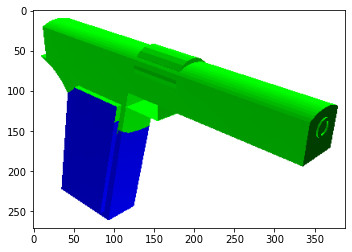

In [7]:
# Load the ShapeNet Dataset
# Default parameters for PartDataset: npoints = 2500, classification = False, class_choice = None, train = True, image=False

d = PartDataset(root = DATA_FOLDER, image=True)
print("Number of objects",len(d))
print('----------')

idx = random.randint(0,len(d))
ps, seg, img = d[idx]

print("Point Cloud Caracteristics:")
print(ps.size(), ps.type(), seg.size(),seg.type())
print('----------')
print("Point Cloud")
print(ps)
print('----------')
print("Label on Part Segmentation")
print(seg)
print('----------')
d = PartDataset(root = DATA_FOLDER, classification = True, image=False)
ps2, cls= d[idx]
print("Label on Classification")
classes_dict_list = list(classes_dict)
print(classes_dict_list[cls.item()])
plt.imshow(np.asarray(img))

In [8]:
from open3d.web_visualizer import draw
#test_vis = JVisualizer()
#test_vis.clear()
clear_output()
test_cloud = o3.geometry.PointCloud()
test_cloud.points = o3.utility.Vector3dVector(ps)
test_cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

draw(test_cloud)

WebVisualizer(window_uid='window_0')

In [9]:
cube_red = o3.geometry.TriangleMesh.create_box(1, 2, 4)
cube_red.compute_vertex_normals()
cube_red.paint_uniform_color((1.0, 0.0, 0.0))
draw(cube_red)

WebVisualizer(window_uid='window_1')

# 3D Deep Learning Model: PointNet

## Build the Model: PointNet

**The model is PointNet.**<p>
![PointNet](https://d3i71xaburhd42.cloudfront.net/c3b6a072288e134f5ae6afe3eebc970ffb65cb68/3-Figure2-1.png)

It's coming from the paper: https://arxiv.org/pdf/1612.00593.pdf

### Build the T-Net

In [10]:
class STN3d(nn.Module):
    """
    T-Net Model. 
    STN stands for Spatial Transformer Network.
    """
    def __init__(self, num_points = 2500):
        super(STN3d, self).__init__()
        self.num_points = num_points
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.mp1(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

sim_data = Variable(torch.rand(32,3,2500))
trans = STN3d()
out = trans(sim_data)
print('stn', out.size())

stn torch.Size([32, 3, 3])


### Build the Feature T-Net + MLP

In [11]:
class PointNetfeat(nn.Module):
    """
    This is the T-Net for Feature Transform.
    There is also MLP part 64,128,1024.
    """
    def __init__(self, num_points = 2500, global_feat = True):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d(num_points = num_points)
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        self.num_points = num_points
        self.global_feat = global_feat
        
    def forward(self, x):
        batchsize = x.size()[0]
        trans = self.stn(x)
        x = x.transpose(2,1)
        x = torch.bmm(x, trans)
        x = x.transpose(2,1)
        x = F.relu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = self.mp1(x)
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, self.num_points)
            return torch.cat([x, pointfeat], 1), trans

In [12]:
pointfeat = PointNetfeat(global_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

global feat torch.Size([32, 1024])


### Build the Classification Head

In [15]:
class PointNetCls(nn.Module):
    """
    Network for Classification: 512, 256, K.
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetCls, self).__init__()
        self.num_points = num_points
        self.feat = PointNetfeat(num_points, global_feat=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
    def forward(self, x):
        x, trans = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1), trans

In [14]:
pointfeat = PointNetfeat(global_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

pointfeat = PointNetfeat(global_feat=False)
out, _ = pointfeat(sim_data)
print('point feat', out.size())

cls = PointNetCls(k = 5)
out, _ = cls(sim_data)
print('class', out.size())

global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])
class torch.Size([32, 5])


### Build the Segmentation Head

In [16]:
class PointNetDenseCls(nn.Module):
    """
    Network for Segmentation
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetDenseCls, self).__init__()
        self.num_points = num_points
        self.k = k
        self.feat = PointNetfeat(num_points, global_feat=False)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        x, trans = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, self.num_points, self.k)
        return x, trans

In [17]:
seg = PointNetDenseCls(k = 3)
print(seg)
out, _ = seg(sim_data)
print('seg', out.size())

PointNetDenseCls(
  (feat): PointNetfeat(
    (stn): STN3d(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (mp1): MaxPool1d(kernel_size=2500, stride=2500, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True

## Train the Model for classification and segmentation

In [17]:
batchSize = 32 #32
num_points = 2500 #2500
workers = 4 #4
nepoch = 25 #25
outf="cls" #'cls'

In [ ]:
# DATASET & DATA LOADER
dataset = PartDataset(root = DATA_FOLDER, classification = True, npoints = num_points)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=workers)

test_dataset = PartDataset(root = DATA_FOLDER, classification = True, train = False, npoints = num_points)
testdataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,shuffle=True, num_workers=workers)

blue = lambda x:'\033[94m' + x + '\033[0m'

# CALL THE MODEL
num_classes = len(classes_dict.items())
classifier = PointNetCls(k = num_classes, num_points = num_points)
#classifier.load_state_dict(torch.load(""))

# DEFINE OPTIMIZERS
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
if torch.cuda.is_available():
    classifier.cuda()

num_batch = len(dataset)/batchSize

# TRAIN ON EPOCHS
for epoch in range(nepoch):
    for i, data in enumerate(dataloader, 0):
        """
        Get Points & Classification Label
        """
        points, target = data
        points, target= Variable(points), Variable(target[:,0])
        points = points.transpose(2,1)
        if torch.cuda.is_available():
            points, target = points.cuda(), target.cuda()
        
        optimizer.zero_grad()
        classifier = classifier.train()
        pred, _ = classifier(points)
        loss = F.nll_loss(pred, target)
        loss.backward()
        optimizer.step()
        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()
        print('[%d: %d/%d] train loss: %f accuracy: %f' %(epoch, i, num_batch, loss.item(),correct.item() / float(batchSize)))

        if i % 10 == 0:
            j, data = next(enumerate(testdataloader, 0))
            points, target = data
            points, target = Variable(points), Variable(target[:,0])
            points = points.transpose(2,1)
            if torch.cuda.is_available():
                points, target = points.cuda(), target.cuda()
            classifier = classifier.eval()
            pred, _ = classifier(points)
            loss = F.nll_loss(pred, target)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            print('[%d: %d/%d] %s loss: %f accuracy: %f' %(epoch, i, num_batch, blue('test'), loss.item(), correct.item()/float(batchSize)))

    torch.save(classifier.state_dict(), '%s/cls_model_%d.pth' % (outf, epoch))

In [19]:
NUM_POINTS = 10000
MODEL_PATH = 'cls/cls_model_24.pth'
num_classes = len(classes_dict.items())
# Create the classification network from pre-trained model
classifier = PointNetCls(k=num_classes, num_points=NUM_POINTS)
if torch.cuda.is_available():
    classifier.cuda()
    classifier.load_state_dict(torch.load(MODEL_PATH))
else:
    classifier.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
classifier.eval()

PointNetCls(
  (feat): PointNetfeat(
    (stn): STN3d(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (mp1): MaxPool1d(kernel_size=10000, stride=10000, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, t

# Visualize the output

[Sample 524 / 1785]


WebVisualizer(window_uid='window_33')

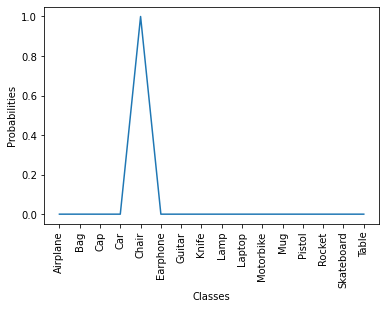

[Sample 295 / 1785]


WebVisualizer(window_uid='window_34')

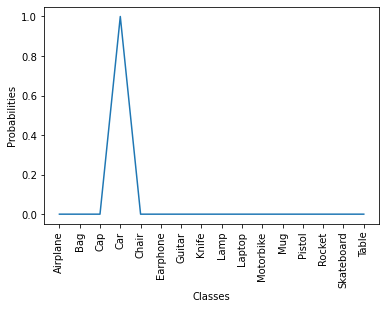

[Sample 646 / 1785]


WebVisualizer(window_uid='window_35')

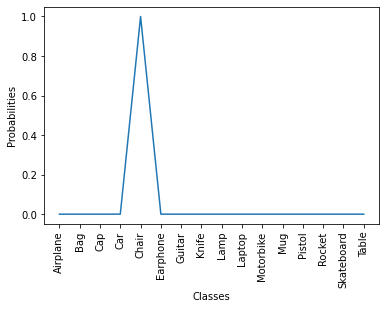

[Sample 1529 / 1785]


WebVisualizer(window_uid='window_36')

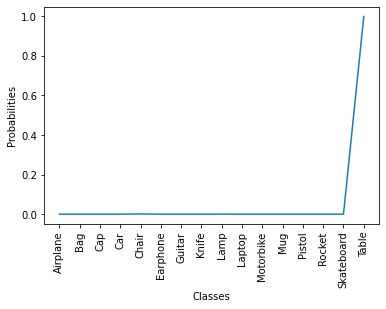

[Sample 210 / 1785]


WebVisualizer(window_uid='window_37')

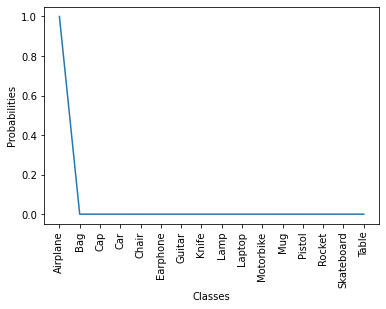

[Sample 995 / 1785]


WebVisualizer(window_uid='window_38')

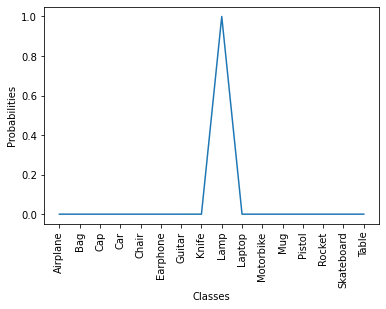

[Sample 378 / 1785]


WebVisualizer(window_uid='window_39')

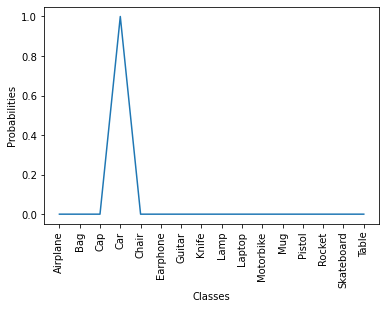

[Sample 142 / 1785]


WebVisualizer(window_uid='window_40')

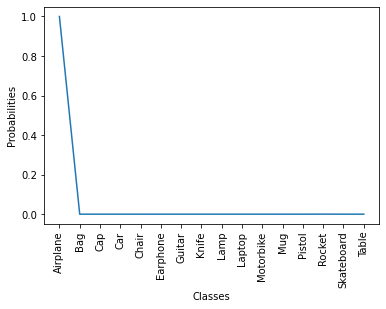

[Sample 1528 / 1785]


WebVisualizer(window_uid='window_41')

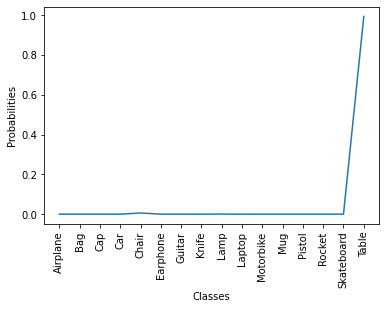

[Sample 291 / 1785]


WebVisualizer(window_uid='window_42')

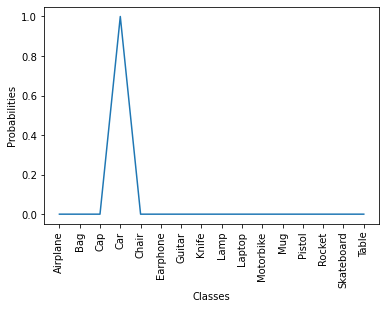

[Sample 880 / 1785]


WebVisualizer(window_uid='window_43')

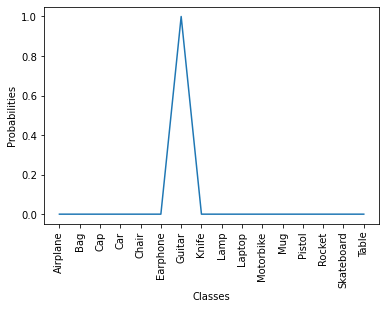

[Sample 309 / 1785]


WebVisualizer(window_uid='window_44')

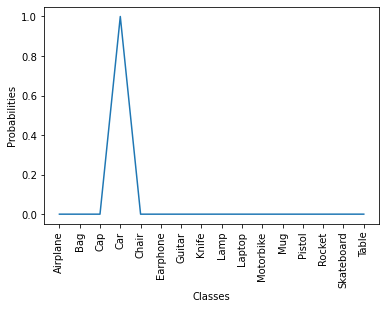

[Sample 1588 / 1785]


WebVisualizer(window_uid='window_45')

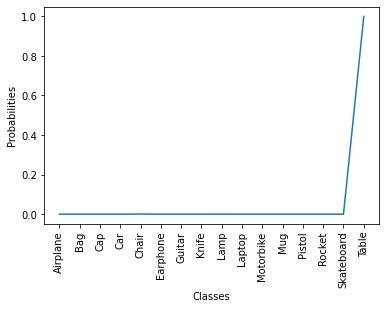

[Sample 9 / 1785]


WebVisualizer(window_uid='window_46')

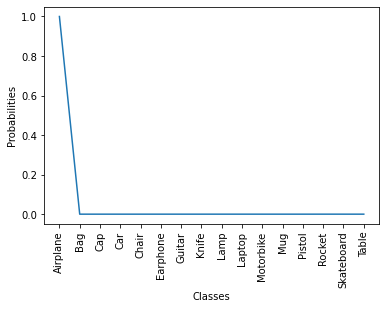

[Sample 1692 / 1785]


WebVisualizer(window_uid='window_47')

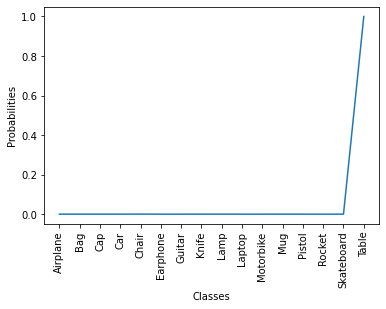

In [25]:
# Three.js based visualizer
#visualizer = JVisualizer()

test_dataset_seg = PartDataset(root=DATA_FOLDER, train=False, classification=False, npoints=NUM_POINTS)

# Basic inference and visualization loop
MAX_SAMPLES = 15
for samples in range(MAX_SAMPLES):
    random_index = randrange(len(test_dataset_seg))
    print('[Sample {} / {}]'.format(random_index, len(test_dataset_seg)))
    
    # clean visualization
    #visualizer.clear()
    #clear_output()

    # get next sample
    point_set, seg = test_dataset_seg.__getitem__(random_index)

    # create cloud for visualization
    cloud = o3.geometry.PointCloud()
    cloud.points = o3.utility.Vector3dVector(point_set)
    cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

    # perform inference in GPU
    points = Variable(point_set.unsqueeze(0))
    points = points.transpose(2, 1)
    if torch.cuda.is_available():
        points = points.cuda()
    pred_logsoft, _ = classifier(points)

    # move data back to cpu for visualization
    pred_logsoft_cpu = pred_logsoft.data.cpu().numpy().squeeze()
    pred_soft_cpu = np.exp(pred_logsoft_cpu)
    pred_class = np.argmax(pred_soft_cpu)

    # let's visualize the input sample
    draw(cloud, bg_color=(255.0, 255.0, 255.0, 255.0))
    #visualizer.show()
    
    # Visualize probabilities
    plt.xticks(list(classes_dict.values()), list(classes_dict.keys()),rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.plot(list(classes_dict.values()), pred_soft_cpu)
    plt.show()

    input('Your object is a [{}] with probability {:0.3}. Press enter to continue!'
          .format(list(classes_dict.keys())[pred_class], pred_soft_cpu[pred_class]))